In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter
from surprise import SVD
from surprise import CoClustering
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [2]:
movies = pd.read_csv('data/10m/movies.dat', sep="::", usecols = [0, 2], names = ['movieId', 'genres'])
ratings = pd.read_csv('data/10m/ratings.dat', sep="::", usecols = [0, 1, 2], names = ['userId', 'movieId', 'rating'])

/home/caym/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/caym/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [5]:
movies['movieId'] = movies['movieId'].astype('int32')

In [9]:
ratings['rating'] = ratings['rating'].astype('float32')
ratings[['userId', 'movieId']] = ratings[['rating', 'movieId']].astype('int32')

In [2]:
movies = pd.read_csv('data/20m/movies.csv', usecols = [0, 1, 2])
ratings = pd.read_csv('data/20m/ratings.csv', usecols = [0, 1, 2])

In [7]:
genres_list = []
for i in movies['genres']:
    genres_list.extend(i.split('|'))
genres = list(set(genres_list))
genres

['Romance',
 'Film-Noir',
 'Fantasy',
 'Children',
 'Adventure',
 'Mystery',
 'IMAX',
 'Thriller',
 'Western',
 'Sci-Fi',
 '(no genres listed)',
 'Animation',
 'Drama',
 'Crime',
 'Comedy',
 'Action',
 'War',
 'Horror',
 'Musical',
 'Documentary']

In [8]:
dict_mov = Counter(genres_list)
val_mov = np.array(list(dict_mov.values()))
val_mov = val_mov / val_mov.sum()
movie_distr = dict(zip(list(dict_mov.keys()), val_mov))

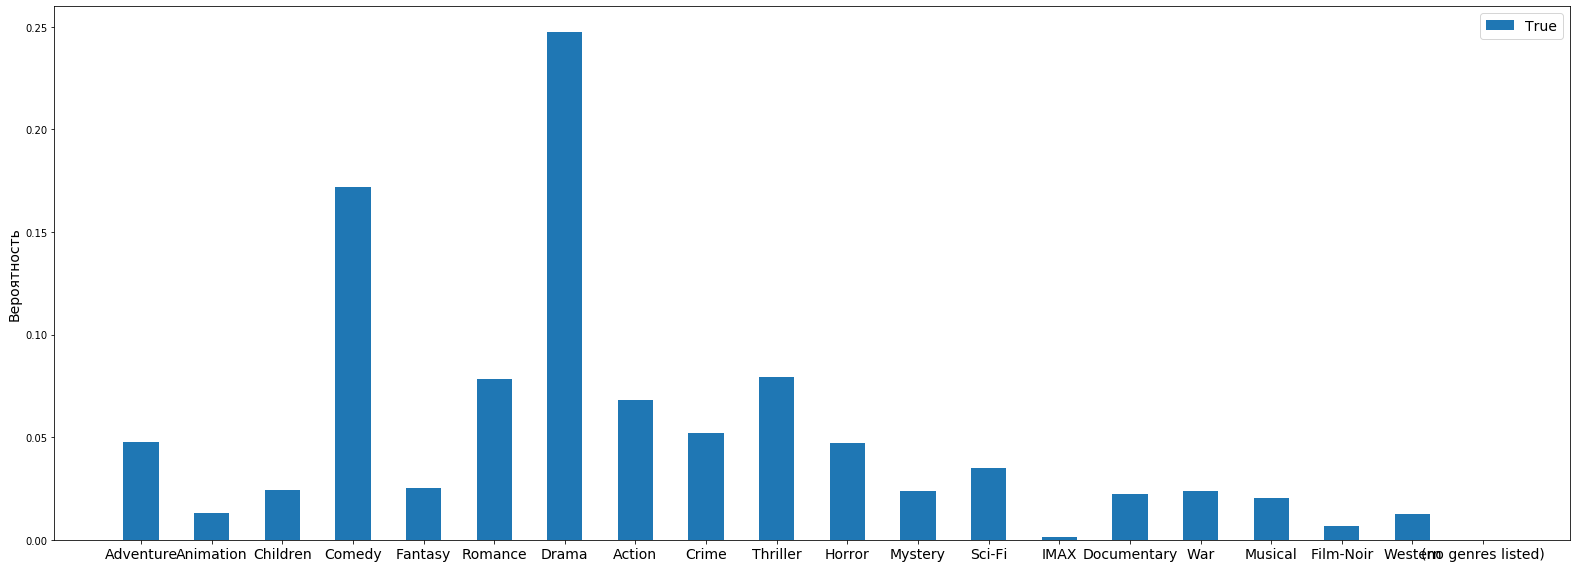

In [9]:
x = np.arange(len(genres))
width = 0.5

fig, ax = plt.subplots(figsize=(22,8))
rects1 = ax.bar(x, movie_distr.values(), width, label='True')

ax.set_ylabel('Вероятность', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(movie_distr.keys(), fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

plt.show()

In [10]:
col_df = ['userId']
col_df.extend(genres)

In [11]:
users = list(set(ratings['userId']))

In [10]:
reader = Reader(line_format='user item rating', sep='::')

In [13]:
data = Dataset.load_from_df(ratings, reader=reader)

In [11]:
data = Dataset.load_from_file('data/10m/ratings.dat', reader=reader)

In [81]:
# data = Dataset.load_builtin('ml-20m')

ValueError: unknown dataset ml-20m. Accepted values are ml-100k, ml-1m, jester.

In [ ]:
algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=3, verbose=True, n_jobs=4)

In [14]:
trainset, testset = train_test_split(data, test_size=.25)

algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

In [15]:
usersId = [i[0] for i in testset]
usersId = list(set(usersId))
pred = pd.DataFrame(predictions)

In [16]:
rec = pred.loc[pred['est']>3.5]

In [17]:
dist = pred.loc[pred['r_ui']>3.5]

In [18]:
rec['iid'].values

array([1466, 8984,  454, ..., 5377, 2383, 1267])

In [20]:
col_df

['userId',
 'Romance',
 'Film-Noir',
 'Fantasy',
 'Children',
 'Adventure',
 'Mystery',
 'IMAX',
 'Thriller',
 'Western',
 'Sci-Fi',
 '(no genres listed)',
 'Animation',
 'Drama',
 'Crime',
 'Comedy',
 'Action',
 'War',
 'Horror',
 'Musical',
 'Documentary']

In [21]:
us = [21 * [0]] * len(usersId)
t_dist = pd.DataFrame(data=us, columns=col_df)
p_dist = pd.DataFrame(data=us, columns=col_df)

In [22]:
p_dist['userId'] = usersId
t_dist['userId'] = usersId

In [24]:
gen_df_rec = pd.DataFrame(data=[[0]*20], columns=genres)
gen_df_true = pd.DataFrame(data=[[0]*20], columns=genres)

In [25]:
gen_df_rec = {x: 0 for x in genres}

In [27]:
for i in tqdm(rec['iid'].values):
    gen = movies.loc[movies['movieId']==int(i), 'genres'].values[0].split('|')
    for k in gen:
        gen_df_rec[k] += 1

In [28]:
gen_df_true = {x: 0 for x in genres}

In [30]:
for i in tqdm(dist['iid'].values):
    gen = movies.loc[movies['movieId']==int(i), 'genres'].values[0].split('|')
    for k in gen:
        gen_df_true[k] += 1

In [31]:
dist_rec = np.array(list(gen_df_rec.values())) / sum(list(gen_df_rec.values()))

In [32]:
gen_df_rec

{'Romance': 279050,
 'Film-Noir': 27767,
 'Fantasy': 137538,
 'Children': 103090,
 'Adventure': 285837,
 'Mystery': 100723,
 'IMAX': 1579,
 'Thriller': 351697,
 'Western': 30510,
 'Sci-Fi': 176117,
 '(no genres listed)': 0,
 'Animation': 77136,
 'Drama': 709056,
 'Crime': 232955,
 'Comedy': 499718,
 'Action': 352207,
 'War': 102074,
 'Horror': 77858,
 'Musical': 69683,
 'Documentary': 19641}

In [33]:
dist_rec

array([0.07678368, 0.0076404 , 0.03784509, 0.02836635, 0.07865119,
       0.02771504, 0.00043448, 0.0967733 , 0.00839516, 0.04846053,
       0.        , 0.02122482, 0.19510456, 0.06410013, 0.1375029 ,
       0.09691363, 0.02808678, 0.02142348, 0.01917404, 0.00540444])

In [ ]:
dist_true = np.array(list(gen_df_true.values())) / sum(list(gen_df_true.values()))

In [36]:
new_gen_df_rec = gen_df_rec.copy()
new_gen_df_true = gen_df_true.copy()

In [37]:
new_gen_df_rec['Action'] += 500
new_gen_df_rec['War'] -= 500
new_gen_df_rec['Western'] -= 800
new_gen_df_rec['Animation'] += 800
new_gen_df_rec['Documentary'] -= 1000
new_gen_df_rec['Comedy'] += 1000

In [28]:
lam = 0.8

In [29]:
new_gen_df_true['Action'] = gen_df_rec['Action'] * lam + (1-lam) * new_gen_df_rec['Action']
new_gen_df_true['Western'] = gen_df_rec['Western'] * lam + (1-lam) * new_gen_df_rec['Western']
new_gen_df_true['War'] = gen_df_rec['War'] * lam + (1-lam) * new_gen_df_rec['War']
new_gen_df_true['Animation'] = gen_df_rec['Animation'] * lam + (1-lam) * new_gen_df_rec['Animation']
new_gen_df_true['Documentary'] = gen_df_rec['Documentary'] * lam + (1-lam) * new_gen_df_rec['Documentary']
new_gen_df_true['Comedy'] = gen_df_rec['Comedy'] * lam + (1-lam) * new_gen_df_rec['Comedy']
new_gen_df_true['Drama'] = gen_df_rec['Drama'] * lam + (1-lam) * new_gen_df_rec['Drama']
new_gen_df_true["Children's"] = gen_df_rec["Children's"] * lam + (1-lam) * new_gen_df_rec["Children's"]
new_gen_df_true['Crime'] = gen_df_rec['Crime'] * lam + (1-lam) * new_gen_df_rec['Crime']
new_gen_df_true['Horror'] = gen_df_rec['Horror'] * lam + (1-lam) * new_gen_df_rec['Horror']
new_gen_df_true['Musical'] = gen_df_rec['Musical'] * lam + (1-lam) * new_gen_df_rec['Musical']
new_gen_df_true['Sci-Fi'] = gen_df_rec['Sci-Fi'] * lam + (1-lam) * new_gen_df_rec['Sci-Fi']
new_gen_df_true['Romance'] = gen_df_rec['Romance'] * lam + (1-lam) * new_gen_df_rec['Romance']
new_gen_df_true['Adventure'] = gen_df_rec['Adventure'] * lam + (1-lam) * new_gen_df_rec['Adventure']
new_gen_df_true['Mystery'] = gen_df_rec['Mystery'] * lam + (1-lam) * new_gen_df_rec['Mystery']
new_gen_df_true['Film-Noir'] = gen_df_rec['Film-Noir'] * lam + (1-lam) * new_gen_df_rec['Film-Noir']
new_gen_df_true['Thriller'] = gen_df_rec['Thriller'] * lam + (1-lam) * new_gen_df_rec['Thriller']


In [17]:
predictions = pd.read_csv('data/predictions.csv')

In [18]:
predictions

,uid,iid,r_ui,est,details
0,4448,1552,4.0,3.663308,{'was_impossible': False}
1,1579,3422,3.0,3.496093,{'was_impossible': False}
2,1891,3932,4.0,4.037267,{'was_impossible': False}
3,3501,1952,4.0,4.526942,{'was_impossible': False}
4,770,1783,1.0,2.468566,{'was_impossible': False}
...,...,...,...,...,...
250048,5453,2021,4.0,3.457776,{'was_impossible': False}
250049,5050,3753,4.0,4.060602,{'was_impossible': False}
250050,3336,1173,1.0,2.725167,{'was_impossible': False}
250051,4736,1459,2.0,2.900455,{'was_impossible': False}


In [168]:
pd.DataFrame(predictions).to_csv('data/predictions.csv', index=None)

In [38]:
u1t[i]/((1-alph)*u1p[i]+alph*u1t[i])

NameError: name 'u1t' is not defined

In [39]:
s

NameError: name 's' is not defined

In [40]:
from math import log
alph = 0.001
s = 0
for i in range(len(u1p)):
    if u1p[i] == 0.0 and u1t[i] == 0.0:
        continue
    temp = u1t[i] * log((u1t[i]+alph)/((1-alph)*u1p[i]+alph*u1t[i]))
    print(temp)
    s += temp

NameError: name 'u1p' is not defined

In [41]:
u1t = t_dist.loc[t_dist['userId']==testUser, genres].values[0]

NameError: name 'testUser' is not defined

In [142]:
u1p = p_dist.loc[p_dist['userId']==testUser, genres].values[0]

In [110]:
testUser = '2237'

In [75]:
train_dist.to_csv('data/train_dist.csv', index=False)

In [98]:
train_dist

,userId,Crime,Mystery,Action,Fantasy,Drama,Thriller,Horror,War,Musical,Film-Noir,Western,Animation,Comedy,Children's,Documentary,Romance,Adventure,Sci-Fi
0,4585,0.031457,0.023179,0.182119,0.024834,0.044702,0.150662,0.048013,0.006623,0.014901,0.009934,0.031457,0.033113,0.082781,0.066225,0.001656,0.026490,0.087748,0.134106
1,3929,0.044807,0.012220,0.180244,0.015275,0.125255,0.107943,0.058045,0.029532,0.011202,0.006110,0.009165,0.006110,0.134420,0.013238,0.001018,0.043788,0.081466,0.120163
2,1181,0.039216,0.023343,0.120915,0.011671,0.206816,0.099907,0.029412,0.035481,0.015406,0.013072,0.014472,0.013072,0.162465,0.022876,0.006069,0.066293,0.059757,0.059757
3,4446,0.031250,0.015625,0.159091,0.026989,0.071023,0.080966,0.055398,0.032670,0.015625,0.001420,0.011364,0.021307,0.197443,0.041193,0.000000,0.051136,0.092330,0.095170
4,4048,0.014876,0.014876,0.104959,0.026446,0.128099,0.043802,0.011570,0.028099,0.034711,0.001653,0.011570,0.036364,0.187603,0.111570,0.001653,0.088430,0.099174,0.054545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,4202,0.088235,0.000000,0.176471,0.058824,0.088235,0.029412,0.000000,0.000000,0.000000,0.029412,0.000000,0.029412,0.088235,0.029412,0.000000,0.058824,0.264706,0.058824
6036,98,0.074074,0.037037,0.148148,0.000000,0.222222,0.074074,0.037037,0.111111,0.000000,0.000000,0.000000,0.000000,0.148148,0.000000,0.000000,0.000000,0.111111,0.037037
6037,4885,0.000000,0.000000,0.125000,0.025000,0.200000,0.100000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,0.000000,0.050000,0.250000,0.050000
6038,4548,0.000000,0.000000,0.181818,0.000000,0.090909,0.121212,0.000000,0.000000,0.030303,0.000000,0.030303,0.030303,0.212121,0.060606,0.000000,0.030303,0.090909,0.121212


In [97]:
train_dist[genres] = genr_dist_train

In [95]:
genr_dist_train

[array([0.03145695, 0.02317881, 0.18211921, 0.02483444, 0.04470199,
        0.15066225, 0.04801325, 0.00662252, 0.01490066, 0.00993377,
        0.03145695, 0.03311258, 0.08278146, 0.06622517, 0.00165563,
        0.02649007, 0.08774834, 0.13410596]),
 array([0.04480652, 0.01221996, 0.1802444 , 0.01527495, 0.12525458,
        0.10794297, 0.05804481, 0.02953157, 0.01120163, 0.00610998,
        0.00916497, 0.00610998, 0.13441955, 0.01323829, 0.00101833,
        0.04378819, 0.0814664 , 0.12016293]),
 array([0.03921569, 0.02334267, 0.12091503, 0.01167134, 0.20681606,
        0.09990663, 0.02941176, 0.03548086, 0.01540616, 0.0130719 ,
        0.01447246, 0.0130719 , 0.16246499, 0.02287582, 0.00606909,
        0.06629318, 0.05975724, 0.05975724]),
 array([0.03125   , 0.015625  , 0.15909091, 0.02698864, 0.07102273,
        0.08096591, 0.05539773, 0.03267045, 0.015625  , 0.00142045,
        0.01136364, 0.02130682, 0.19744318, 0.04119318, 0.        ,
        0.05113636, 0.09232955, 0.09517045]),


In [94]:
genr_dist_train = []
for i in train_dist[genres].values:
    genr_dist_train.append(i/sum(i))

In [76]:
train_dist

,userId,Crime,Mystery,Action,Fantasy,Drama,Thriller,Horror,War,Musical,Film-Noir,Western,Animation,Comedy,Children's,Documentary,Romance,Adventure,Sci-Fi
0,4585,19,14,110,15,27,91,29,4,9,6,19,20,50,40,1,16,53,81
1,3929,44,12,177,15,123,106,57,29,11,6,9,6,132,13,1,43,80,118
2,1181,84,50,259,25,443,214,63,76,33,28,31,28,348,49,13,142,128,128
3,4446,22,11,112,19,50,57,39,23,11,1,8,15,139,29,0,36,65,67
4,4048,18,18,127,32,155,53,14,34,42,2,14,44,227,135,2,107,120,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,4202,3,0,6,2,3,1,0,0,0,1,0,1,3,1,0,2,9,2
6036,98,2,1,4,0,6,2,1,3,0,0,0,0,4,0,0,0,3,1
6037,4885,0,0,5,1,8,4,0,5,0,0,0,0,3,0,0,2,10,2
6038,4548,0,0,6,0,3,4,0,0,1,0,1,1,7,2,0,1,3,4


In [74]:
for i in tqdm(range(len(trainUsersId))):
    movId = [z[0] for z in trainset.ur[i]]
    for j in movId:
        gen = movies.loc[movies['movieId']==int(trainMovieId[j]), 'genre'].values[0].split('|')
        for k in gen:
            train_dist.loc[train_dist['userId']==trainUsersId[i], k] += 1

In [73]:
us = [19 * [0]] * len(trainUsersId)
train_dist = pd.DataFrame(data=us, columns=col_df)
train_dist['userId'] = trainUsersId

In [42]:
trainMovieId = []
for i in trainset.all_items():
    trainMovieId.append(trainset.to_raw_iid(i))

In [40]:
trainUsersId = []
for i in trainset.all_users():
    trainUsersId.append(trainset.to_raw_uid(i))

In [42]:
t_dist = pd.read_csv('data/t_dist.csv')

In [104]:
t_dist.to_csv('data/t_dist.csv', index=False)

In [43]:
t_dist[genres] = genr_dist_true

NameError: name 'genr_dist_true' is not defined

In [102]:
genr_dist_true = []
for i in t_dist[genres].values:
    genr_dist_true.append(i/sum(i))

/home/caym/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
t_dist

,userId,Crime,Mystery,Action,Fantasy,Drama,Thriller,Horror,War,Musical,Film-Noir,Western,Animation,Comedy,Children's,Documentary,Romance,Adventure,Sci-Fi
0,1353,0.000000,0.000000,0.050000,0.000000,0.050000,0.000000,0.050000,0.000000,0.050000,0.050000,0.000000,0.200000,0.350000,0.050000,0.000000,0.000000,0.100000,0.050000
1,4564,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.400000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.200000
2,2237,0.034483,0.000000,0.086207,0.008621,0.387931,0.051724,0.008621,0.025862,0.008621,0.000000,0.008621,0.000000,0.198276,0.000000,0.008621,0.129310,0.017241,0.025862
3,3473,0.056338,0.014085,0.084507,0.014085,0.323944,0.028169,0.000000,0.028169,0.000000,0.014085,0.000000,0.000000,0.197183,0.000000,0.000000,0.211268,0.014085,0.014085
4,470,0.000000,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.000000,0.194444,0.000000,0.000000,0.138889,0.250000,0.222222,0.000000,0.083333,0.083333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,744,0.048780,0.024390,0.158537,0.036585,0.195122,0.036585,0.012195,0.085366,0.012195,0.000000,0.000000,0.012195,0.121951,0.024390,0.000000,0.012195,0.073171,0.146341
6036,1575,0.060606,0.000000,0.272727,0.090909,0.181818,0.030303,0.030303,0.060606,0.000000,0.000000,0.000000,0.030303,0.030303,0.000000,0.000000,0.000000,0.090909,0.121212
6037,4890,0.000000,0.000000,0.000000,0.000000,0.360000,0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.320000,0.000000,0.120000,0.160000,0.000000,0.000000
6038,4860,0.222222,0.055556,0.166667,0.055556,0.111111,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.055556,0.055556,0.055556


In [37]:
for i in tqdm(usersId):
    movId = dist.loc[dist['uid']==i, 'iid']
    for j in movId:
        gen = movies.loc[movies['movieId']==int(j), 'genre'].values[0].split('|')
        for k in gen:
            t_dist.loc[t_dist['userId']==i, k] += 1

In [45]:
p_dist = pd.read_csv('data/p_dist.csv')

In [101]:
p_dist.to_csv('data/p_dist.csv', index=False)

In [100]:
p_dist[genres] = genr_dist_pred

In [99]:
genr_dist_pred = []
for i in p_dist[genres].values:
    genr_dist_pred.append(i/sum(i))

/home/caym/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
p_dist

,userId,Crime,Mystery,Action,Fantasy,Drama,Thriller,Horror,War,Musical,Film-Noir,Western,Animation,Comedy,Children's,Documentary,Romance,Adventure,Sci-Fi
0,1353,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
1,4564,0.125000,0.062500,0.062500,0.000000,0.125000,0.062500,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0.187500,0.000000,0.000000,0.062500,0.000000,0.125000
2,2237,0.031008,0.007752,0.100775,0.007752,0.325581,0.046512,0.015504,0.023256,0.007752,0.000000,0.007752,0.000000,0.217054,0.000000,0.015504,0.124031,0.038760,0.031008
3,3473,0.042553,0.031915,0.085106,0.010638,0.276596,0.031915,0.000000,0.021277,0.000000,0.010638,0.000000,0.000000,0.255319,0.000000,0.000000,0.202128,0.021277,0.010638
4,470,0.000000,0.000000,0.024390,0.000000,0.024390,0.000000,0.000000,0.000000,0.195122,0.000000,0.000000,0.170732,0.243902,0.219512,0.000000,0.073171,0.048780,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,744,0.034091,0.011364,0.193182,0.022727,0.136364,0.068182,0.011364,0.045455,0.000000,0.000000,0.011364,0.022727,0.136364,0.011364,0.000000,0.022727,0.136364,0.136364
6036,1575,0.051282,0.000000,0.307692,0.051282,0.230769,0.025641,0.025641,0.076923,0.000000,0.000000,0.000000,0.025641,0.000000,0.000000,0.000000,0.000000,0.076923,0.128205
6037,4890,0.000000,0.000000,0.032258,0.032258,0.354839,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.290323,0.000000,0.096774,0.129032,0.000000,0.032258
6038,4860,0.181818,0.090909,0.181818,0.045455,0.136364,0.136364,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000,0.000000,0.045455,0.045455,0.045455


In [48]:
predictions.drop(['details'], inplace=True, axis=1)

In [49]:
predictions

,uid,iid,r_ui,est
0,4448,1552,4.0,3.663308
1,1579,3422,3.0,3.496093
2,1891,3932,4.0,4.037267
3,3501,1952,4.0,4.526942
4,770,1783,1.0,2.468566
...,...,...,...,...
250048,5453,2021,4.0,3.457776
250049,5050,3753,4.0,4.060602
250050,3336,1173,1.0,2.725167
250051,4736,1459,2.0,2.900455


In [81]:
lambd = 0.2

In [70]:
t_dist.loc[t_dist['userId']==4448, 'Crime']

5584    0.02963
Name: Crime, dtype: float64

In [78]:
movies.loc[movies['movieId']==int(1), 'genre'].values[0].split('|')

['Animation', "Children's", 'Comedy']

In [150]:
cal = []
alpha = 0.001
for i in predictions.values:
    genr = movies.loc[movies['movieId']==int(i[1]), 'genre'].values[0].split('|')
    CL = 0
    for g in genr:
        p = t_dist.loc[t_dist['userId']==int(i[0]), g].values[0]
        q = p_dist.loc[p_dist['userId']==int(i[0]), g].values[0]
        q = (1-alpha)*q+alpha*p
        if np.isnan(p) or int(p)==0:
            CL = q
            continue
        CL += p*log(p/q)
    cal.append(abs((1-lambd)*i[3]-lambd*CL))

In [151]:
from sklearn.metrics import mean_squared_error as mse

In [152]:
y_true = predictions['r_ui']
y_pred = predictions['est']
y_cal = cal

In [153]:
len(np.array(y_true.values, dtype=np.float))

250053

In [157]:
y_cal

[2.908420859368142,
 2.789895761146455,
 3.2053197682441583,
 3.5699388326685177,
 1.9454484621332242,
 3.2122478161742274,
 3.097757933451179,
 2.4066211596622122,
 2.8004073982169175,
 3.502594541477908,
 2.88778015838758,
 1.4945552196817697,
 2.7334888432912314,
 3.7136436751863346,
 3.4450508363649277,
 3.1109519991777637,
 2.7572556848260557,
 2.9488905898589413,
 3.688108293457044,
 3.4662505687675793,
 3.374772726010157,
 3.3378067457029372,
 3.3217302020008317,
 3.3568865116103406,
 nan,
 2.9087700193942707,
 3.0340981893418215,
 2.3809712626673387,
 3.121440896478215,
 1.995103845711777,
 1.8710602996824097,
 1.798992361617797,
 2.643598003899915,
 3.6590408126736507,
 3.1979049128740025,
 3.0562405015803464,
 2.5588398864739625,
 0.7499722222222223,
 3.799859058714688,
 3.901394653057498,
 2.5900344602439844,
 2.554940208151677,
 3.664963232045811,
 3.426100480044334,
 2.7790205206666503,
 2.9063728253438046,
 3.698166974885275,
 3.520513012393575,
 2.3291781834771754,
 1.96

In [161]:
for i in range(n):
    if np.isnan(y_cal[i]):
        y_cal[i] = y_pred.values[i]

In [164]:
mse(y_true, y_pred), mse(y_true, y_cal)

(0.8375663707459015, 1.3758211258431612)

In [166]:
mse(y_true, y_pred, squared=False), mse(y_true, y_cal, squared=False)

(0.9151865223799471, 1.1729540169346628)

In [34]:
for i in tqdm(usersId):
    movId = rec.loc[rec['uid']==i, 'iid'].values
    for j in movId:
        gen = movies.loc[movies['movieId']==int(j), 'genre'].values[0].split('|')
        for k in gen:
            p_dist.loc[p_dist['userId']==i, k] += 1

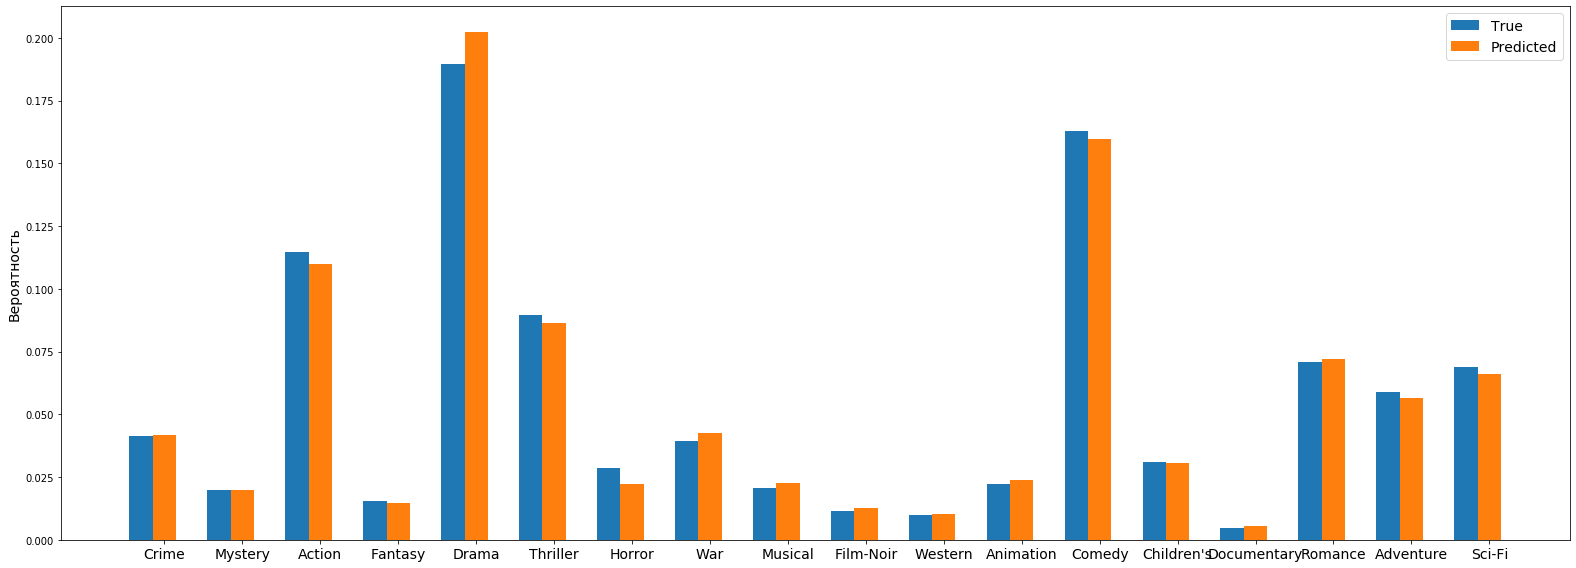

In [33]:
x = np.arange(len(genres))
width = 0.3

fig, ax = plt.subplots(figsize=(22,8))
rects1 = ax.bar(x - 3*width/3, dist_true, width, label='True')
rects2 = ax.bar(x, dist_rec, width, label='Predicted')
rects3 = ax.bar(x + 3*width/3, new_dist_true_gr, width, label='Calibrated')

ax.set_ylabel('Вероятность', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(genres, fontsize=14)
ax.legend(fontsize=14)
fig.tight_layout()

plt.show()

In [31]:
new_gen_df_true

{'Crime': 12852.0,
 'Mystery': 6115.0,
 'Action': 33766.0,
 'Fantasy': 4624,
 'Drama': 62046.0,
 'Thriller': 26463.0,
 'Horror': 6873.0,
 'War': 12939.0,
 'Musical': 6944.0,
 'Film-Noir': 3919.0,
 'Western': 3008.0,
 'Animation': 7422.0,
 'Comedy': 49212.0,
 "Children's": 9364.0,
 'Documentary': 1440.0,
 'Romance': 22130.0,
 'Adventure': 17272.0,
 'Sci-Fi': 20255.0}

In [31]:
dist_rec

array([0.01040275, 0.08663742, 0.07272147, 0.02993397, 0.01488062,
       0.02247737, 0.0051916 , 0.04286897, 0.01304254, 0.0231585 ,
       0.15936867, 0.04167617, 0.05698372, 0.20130882, 0.02191682,
       0.06644136, 0.11072474, 0.0202645 ])

In [33]:
new_dist_true_gr = new_gen_df_true.iloc[0] / new_gen_df_true.iloc[0].sum()

AttributeError: 'dict' object has no attribute 'iloc'